In [ ]:
"""
Fake Job Posting Detector - Professional Training Script
Author: Your Name
Date: 2024
Description: Train a deep learning model to detect fraudulent job postings
"""

import pandas as pd
import numpy as np
import torch
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
import kagglehub

# =====================================================
# CONFIGURATION
# =====================================================
class Config:
    MODEL_NAME = "distilbert-base-uncased"
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    LEARNING_RATE = 5e-5
    NUM_EPOCHS = 4
    WARMUP_STEPS = 100
    WEIGHT_DECAY = 0.01
    TRAIN_SIZE = 0.7  # 70% train
    VAL_SIZE = 0.15   # 15% validation
    TEST_SIZE = 0.15  # 15% test
    RANDOM_STATE = 42
    OUTPUT_DIR = './job_fraud_detector_final'

config = Config()

print("=" * 70)
print(" " * 15 + "🕵️  FAKE JOB POSTING DETECTOR")
print(" " * 20 + "Training Pipeline v1.0")
print("=" * 70)
print(f"\n📅 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# =====================================================
# 1. DATA LOADING
# =====================================================
print("\n" + "=" * 70)
print("STEP 1: DATA LOADING")
print("=" * 70)

print("📥 Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
df = pd.read_csv(path + "/fake_job_postings.csv")

print(f"\n✅ Dataset loaded successfully!")
print(f"   Total samples: {len(df):,}")
print(f"   Fraudulent jobs: {df['fraudulent'].sum():,} ({df['fraudulent'].mean()*100:.1f}%)")
print(f"   Legitimate jobs: {(~df['fraudulent'].astype(bool)).sum():,} ({(1-df['fraudulent'].mean())*100:.1f}%)")

# =====================================================
# 2. DATA PREPROCESSING
# =====================================================
print("\n" + "=" * 70)
print("STEP 2: DATA PREPROCESSING")
print("=" * 70)

print("🔧 Combining text features...")
df['full_text'] = (
    df['title'].fillna('') + ' [SEP] ' +
    df['company_profile'].fillna('') + ' [SEP] ' +
    df['description'].fillna('') + ' [SEP] ' +
    df['requirements'].fillna('') + ' [SEP] ' +
    df['benefits'].fillna('')
)

# Remove very short or empty texts
initial_len = len(df)
df = df[df['full_text'].str.len() > 50].reset_index(drop=True)
print(f"✅ Removed {initial_len - len(df)} samples with insufficient text")

# Balance dataset
print("\n🎯 Balancing dataset...")
df_fake = df[df['fraudulent'] == 1]
df_real = df[df['fraudulent'] == 0]

# Sample equal amounts for balanced training
sample_size = min(len(df_fake), len(df_real), 1500)  # Cap at 1500 per class
df_fake_sampled = df_fake.sample(n=sample_size, random_state=config.RANDOM_STATE)
df_real_sampled = df_real.sample(n=sample_size, random_state=config.RANDOM_STATE)

df_balanced = pd.concat([df_fake_sampled, df_real_sampled]).sample(
    frac=1,
    random_state=config.RANDOM_STATE
).reset_index(drop=True)

print(f"✅ Balanced dataset created:")
print(f"   Fake jobs: {df_balanced['fraudulent'].sum():,}")
print(f"   Real jobs: {(~df_balanced['fraudulent'].astype(bool)).sum():,}")
print(f"   Total: {len(df_balanced):,}")

# =====================================================
# 3. TRAIN/VAL/TEST SPLIT
# =====================================================
print("\n" + "=" * 70)
print("STEP 3: DATA SPLITTING")
print("=" * 70)

# First split: separate test set
train_val_df, test_df = train_test_split(
    df_balanced[['full_text', 'fraudulent']],
    test_size=config.TEST_SIZE,
    random_state=config.RANDOM_STATE,
    stratify=df_balanced['fraudulent']
)

# Second split: separate train and validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=config.VAL_SIZE / (config.TRAIN_SIZE + config.VAL_SIZE),
    random_state=config.RANDOM_STATE,
    stratify=train_val_df['fraudulent']
)

print(f"✅ Data split completed:")
print(f"   Training set:   {len(train_df):,} samples ({len(train_df)/len(df_balanced)*100:.1f}%)")
print(f"   Validation set: {len(val_df):,} samples ({len(val_df)/len(df_balanced)*100:.1f}%)")
print(f"   Test set:       {len(test_df):,} samples ({len(test_df)/len(df_balanced)*100:.1f}%)")

# Verify balance in each split
print(f"\n📊 Class distribution:")
print(f"   Train - Fake: {train_df['fraudulent'].sum()}, Real: {(~train_df['fraudulent'].astype(bool)).sum()}")
print(f"   Val   - Fake: {val_df['fraudulent'].sum()}, Real: {(~val_df['fraudulent'].astype(bool)).sum()}")
print(f"   Test  - Fake: {test_df['fraudulent'].sum()}, Real: {(~test_df['fraudulent'].astype(bool)).sum()}")

# =====================================================
# 4. MODEL LOADING
# =====================================================
print("\n" + "=" * 70)
print("STEP 4: MODEL INITIALIZATION")
print("=" * 70)

print(f"🤖 Loading {config.MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification"
)

print(f"✅ Model loaded successfully!")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Device: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")

# =====================================================
# 5. DATASET CLASS
# =====================================================
class JobPostingDataset(Dataset):
    """Custom Dataset for Job Postings"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
print("\n📦 Creating PyTorch datasets...")
train_dataset = JobPostingDataset(
    train_df['full_text'],
    train_df['fraudulent'],
    tokenizer,
    config.MAX_LENGTH
)
val_dataset = JobPostingDataset(
    val_df['full_text'],
    val_df['fraudulent'],
    tokenizer,
    config.MAX_LENGTH
)
test_dataset = JobPostingDataset(
    test_df['full_text'],
    test_df['fraudulent'],
    tokenizer,
    config.MAX_LENGTH
)

print(f"✅ Datasets created:")
print(f"   Train: {len(train_dataset):,} samples")
print(f"   Val:   {len(val_dataset):,} samples")
print(f"   Test:  {len(test_dataset):,} samples")

# =====================================================
# 6. TRAINING CONFIGURATION
# =====================================================
print("\n" + "=" * 70)
print("STEP 5: TRAINING CONFIGURATION")
print("=" * 70)

training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,
    num_train_epochs=config.NUM_EPOCHS,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.BATCH_SIZE * 2,
    learning_rate=config.LEARNING_RATE,
    warmup_steps=config.WARMUP_STEPS,
    weight_decay=config.WEIGHT_DECAY,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to='none',
    seed=config.RANDOM_STATE,
    dataloader_num_workers=0,
    dataloader_pin_memory=False,
)

def compute_metrics(pred):
    """Compute evaluation metrics"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted')
    }

print(f"✅ Configuration:")
print(f"   Epochs: {config.NUM_EPOCHS}")
print(f"   Batch size: {config.BATCH_SIZE}")
print(f"   Learning rate: {config.LEARNING_RATE}")
print(f"   Max length: {config.MAX_LENGTH}")

# =====================================================
# 7. TRAINING
# =====================================================
print("\n" + "=" * 70)
print("STEP 6: MODEL TRAINING")
print("=" * 70)
print("\n🏋️  Training started...\n")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

train_result = trainer.train()

print("\n✅ Training completed!")
print(f"   Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"   Training loss: {train_result.metrics['train_loss']:.4f}")

# =====================================================
# 8. EVALUATION ON VALIDATION SET
# =====================================================
print("\n" + "=" * 70)
print("STEP 7: VALIDATION EVALUATION")
print("=" * 70)

val_results = trainer.evaluate(val_dataset)
print(f"\n📊 Validation Results:")
print(f"   Accuracy:  {val_results['eval_accuracy']:.4f} ({val_results['eval_accuracy']*100:.2f}%)")
print(f"   F1 Score:  {val_results['eval_f1']:.4f}")
print(f"   Precision: {val_results['eval_precision']:.4f}")
print(f"   Recall:    {val_results['eval_recall']:.4f}")

# =====================================================
# 9. FINAL EVALUATION ON TEST SET
# =====================================================
print("\n" + "=" * 70)
print("STEP 8: FINAL TEST EVALUATION")
print("=" * 70)

test_results = trainer.evaluate(test_dataset)
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

print(f"\n🎯 Final Test Results:")
print(f"   Accuracy:  {test_results['eval_accuracy']:.4f} ({test_results['eval_accuracy']*100:.2f}%)")
print(f"   F1 Score:  {test_results['eval_f1']:.4f}")
print(f"   Precision: {test_results['eval_precision']:.4f}")
print(f"   Recall:    {test_results['eval_recall']:.4f}")

# Classification Report
print(f"\n📈 Detailed Classification Report:")
print(classification_report(
    test_df['fraudulent'].values,
    preds,
    target_names=['Real Job', 'Fake Job'],
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(test_df['fraudulent'].values, preds)
tn, fp, fn, tp = cm.ravel()

print(f"📊 Confusion Matrix:")
print(f"                    Predicted")
print(f"                Real    Fake")
print(f"Actual Real:    {tn:4d}    {fp:4d}")
print(f"Actual Fake:    {fn:4d}    {tp:4d}")

print(f"\n📐 Interpretation:")
print(f"   ✅ True Positives (Fake detected):  {tp}/{tp+fn} ({tp/(tp+fn)*100:.1f}%)")
print(f"   ✅ True Negatives (Real detected):  {tn}/{tn+fp} ({tn/(tn+fp)*100:.1f}%)")
print(f"   ❌ False Positives (False alarms):  {fp}")
print(f"   ❌ False Negatives (Missed fakes):  {fn}")

# Check for overfitting
val_acc = val_results['eval_accuracy']
test_acc = test_results['eval_accuracy']
diff = abs(val_acc - test_acc)

print(f"\n🔍 Overfitting Check:")
print(f"   Validation Accuracy: {val_acc:.4f}")
print(f"   Test Accuracy:       {test_acc:.4f}")
print(f"   Difference:          {diff:.4f}")

if diff < 0.02:
    print(f"   Status: ✅ No overfitting detected (difference < 2%)")
elif diff < 0.05:
    print(f"   Status: ⚠️  Slight overfitting (difference 2-5%)")
else:
    print(f"   Status: ❌ Overfitting detected (difference > 5%)")

# =====================================================
# 10. SAVE MODEL
# =====================================================
print("\n" + "=" * 70)
print("STEP 9: MODEL SAVING")
print("=" * 70)

print(f"💾 Saving model to {config.OUTPUT_DIR}...")
model.save_pretrained(config.OUTPUT_DIR)
tokenizer.save_pretrained(config.OUTPUT_DIR)

# Save configuration
config_dict = {
    'model_name': config.MODEL_NAME,
    'max_length': config.MAX_LENGTH,
    'accuracy': test_results['eval_accuracy'],
    'f1_score': test_results['eval_f1'],
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open(f'{config.OUTPUT_DIR}/config.json', 'w') as f:
    json.dump(config_dict, f, indent=4)

print(f"✅ Model saved successfully!")

# =====================================================
# 11. TEST PREDICTIONS
# =====================================================
print("\n" + "=" * 70)
print("STEP 10: TESTING PREDICTIONS")
print("=" * 70)

def predict_job(text):
    """Make prediction on new text"""
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=config.MAX_LENGTH,
        return_tensors='pt'
    )

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs).item()
        confidence = probs[0][pred].item()

    return pred, confidence

test_examples = [
    "We are hiring a Senior Software Engineer with 5+ years of experience in Python, Django, and React. Competitive salary, health insurance, and remote work options available. Apply through our website.",
    "URGENT! Make $5000/week from home! No experience needed! Just pay $99 registration fee to start earning TODAY! Limited spots available!",
    "Marketing Manager position at Fortune 500 company. MBA preferred. Responsibilities include team management and strategy development. Send resume to hr@company.com"
]

print("\n🧪 Sample Predictions:\n")
for i, example in enumerate(test_examples, 1):
    pred, conf = predict_job(example)
    label = "FAKE ❌" if pred == 1 else "REAL ✅"
    print(f"Example {i}:")
    print(f"Text: {example[:80]}...")
    print(f"Prediction: {label} (Confidence: {conf:.1%})")
    print()

# =====================================================
# SUMMARY
# =====================================================
print("=" * 70)
print(" " * 25 + "TRAINING SUMMARY")
print("=" * 70)
print(f"\n📊 Dataset:")
print(f"   Total samples: {len(df_balanced):,}")
print(f"   Train/Val/Test: {len(train_df)}/{len(val_df)}/{len(test_df)}")

print(f"\n🎯 Performance:")
print(f"   Test Accuracy: {test_results['eval_accuracy']*100:.2f}%")
print(f"   Test F1 Score: {test_results['eval_f1']:.4f}")

print(f"\n💾 Model:")
print(f"   Saved to: {config.OUTPUT_DIR}")
print(f"   Ready for deployment!")

print(f"\n⏭️  Next Steps:")
print(f"   Run: streamlit run app.py")

print("\n" + "=" * 70)
print(f"✅ Pipeline completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

               🕵️  FAKE JOB POSTING DETECTOR
                    Training Pipeline v1.0

📅 Started at: 2025-12-12 12:05:55

STEP 1: DATA LOADING
📥 Downloading dataset from Kaggle...
Using Colab cache for faster access to the 'real-or-fake-fake-jobposting-prediction' dataset.

✅ Dataset loaded successfully!
   Total samples: 17,880
   Fraudulent jobs: 866 (4.8%)
   Legitimate jobs: 17,014 (95.2%)

STEP 2: DATA PREPROCESSING
🔧 Combining text features...
✅ Removed 2 samples with insufficient text

🎯 Balancing dataset...
✅ Balanced dataset created:
   Fake jobs: 864
   Real jobs: 864
   Total: 1,728

STEP 3: DATA SPLITTING
✅ Data split completed:
   Training set:   1,208 samples (69.9%)
   Validation set: 260 samples (15.0%)
   Test set:       260 samples (15.0%)

📊 Class distribution:
   Train - Fake: 604, Real: 604
   Val   - Fake: 130, Real: 130
   Test  - Fake: 130, Real: 130

STEP 4: MODEL INITIALIZATION
🤖 Loading distilbert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!
   Parameters: 66,955,010
   Device: CPU

📦 Creating PyTorch datasets...
✅ Datasets created:
   Train: 1,208 samples
   Val:   260 samples
   Test:  260 samples

STEP 5: TRAINING CONFIGURATION
✅ Configuration:
   Epochs: 4
   Batch size: 16
   Learning rate: 5e-05
   Max length: 128

STEP 6: MODEL TRAINING

🏋️  Training started...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.640200,0.339392,0.857692,0.857081,0.863915,0.857692
2,0.264300,0.344240,0.888462,0.888262,0.891263,0.888462
3,0.111500,0.348811,0.911538,0.911432,0.913520,0.911538
4,0.050600,0.356304,0.911538,0.911527,0.911758,0.911538



✅ Training completed!
   Total training time: 3181.17 seconds
   Training loss: 0.2382

STEP 7: VALIDATION EVALUATION



📊 Validation Results:
   Accuracy:  0.9115 (91.15%)
   F1 Score:  0.9115
   Precision: 0.9118
   Recall:    0.9115

STEP 8: FINAL TEST EVALUATION

🎯 Final Test Results:
   Accuracy:  0.9231 (92.31%)
   F1 Score:  0.9231
   Precision: 0.9231
   Recall:    0.9231

📈 Detailed Classification Report:
              precision    recall  f1-score   support

    Real Job     0.9231    0.9231    0.9231       130
    Fake Job     0.9231    0.9231    0.9231       130

    accuracy                         0.9231       260
   macro avg     0.9231    0.9231    0.9231       260
weighted avg     0.9231    0.9231    0.9231       260

📊 Confusion Matrix:
                    Predicted
                Real    Fake
Actual Real:     120      10
Actual Fake:      10     120

📐 Interpretation:
   ✅ True Positives (Fake detected):  120/130 (92.3%)
   ✅ True Negatives (Real detected):  120/130 (92.3%)
   ❌ False Positives (False alarms):  10
   ❌ False Negatives (Missed fakes):  10

🔍 Overfitting Check:
   Vali

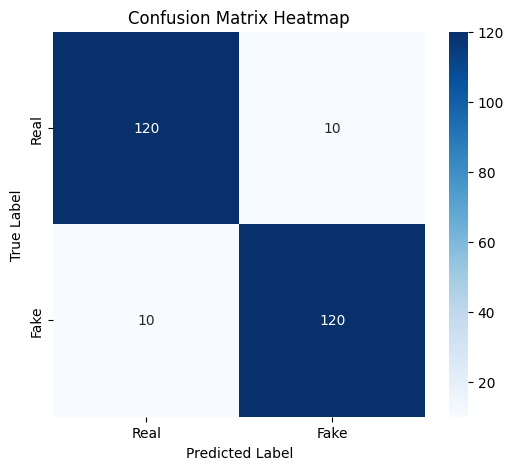

In [ ]:
cm = confusion_matrix(test_df['fraudulent'].values, preds)

import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"]
)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


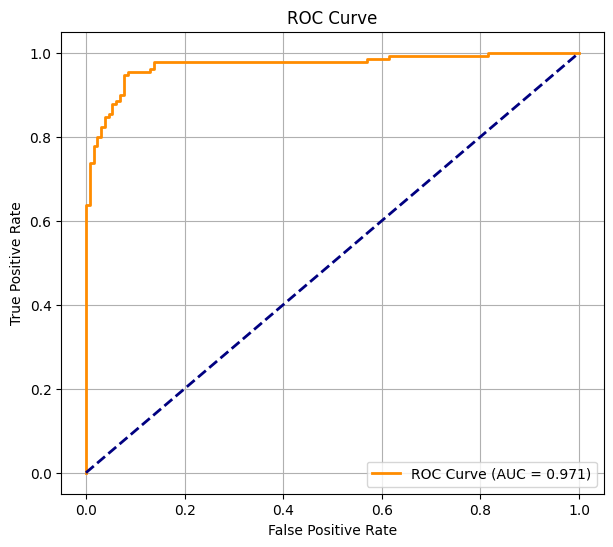

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities for class 1 (Fake)
probs = predictions.predictions
probs = torch.softmax(torch.tensor(probs), dim=1).numpy()
fake_probs = probs[:, 1]

# Compute ROC
fpr, tpr, thresholds = roc_curve(test_df['fraudulent'].values, fake_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


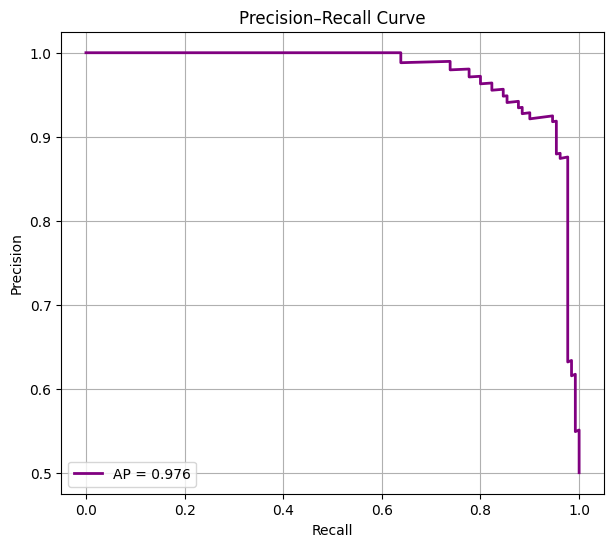

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(test_df['fraudulent'].values, fake_probs)
ap_score = average_precision_score(test_df['fraudulent'].values, fake_probs)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


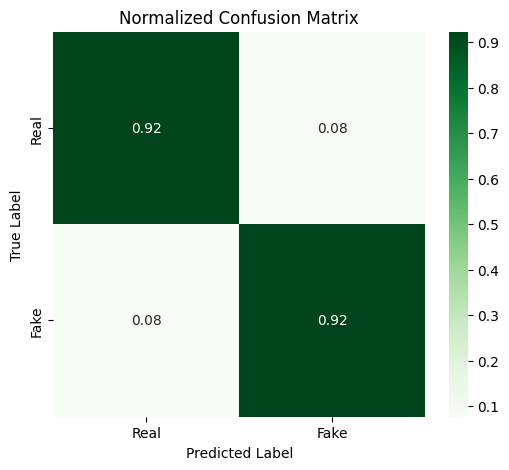

In [ ]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(6, 5))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_norm, annot=True, fmt=".2f", cmap="Greens",
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"]
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


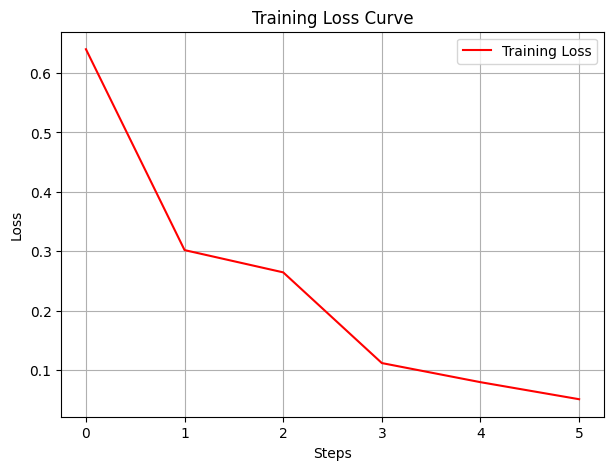

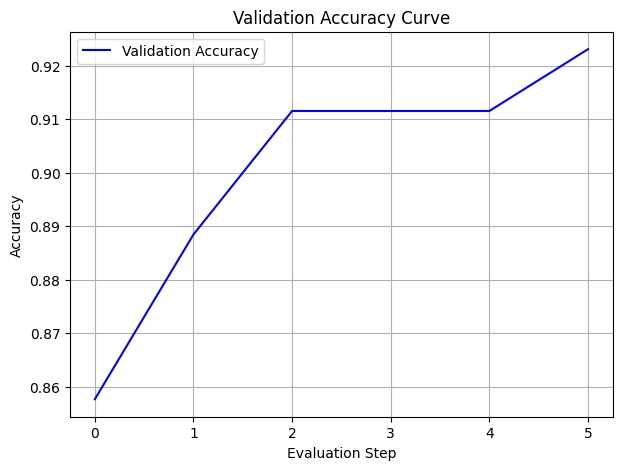

In [ ]:
training_logs = trainer.state.log_history

# Extract loss & accuracy
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_acc = [log["eval_accuracy"] for log in training_logs if "eval_accuracy" in log]

# Plot Loss Curve
plt.figure(figsize=(7, 5))
plt.plot(loss_values, label="Training Loss", color="red")
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(7, 5))
plt.plot(eval_acc, label="Validation Accuracy", color="blue")
plt.title("Validation Accuracy Curve")
plt.xlabel("Evaluation Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()
